In [2]:
from torchvision.datasets import USPS
from torchvision import transforms

transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

train_dataset = USPS(root='USPS/train', train=True, transform=transform, download=True)
test_dataset = USPS(root='USPS/test', train=False, transform=transform, download=True)


In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class USPostalDataset(Dataset):
    """读取数据集"""
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        if self.train:
            self.data_dir = os.path.join(self.root_dir, 'train')
        else:
            self.data_dir = os.path.join(self.root_dir, 'test')

        self.imgs = []
        self.labels = []

        for label in os.listdir(self.data_dir):
            label_dir = os.path.join(self.data_dir, label)
            for img_name in os.listdir(label_dir):
                self.imgs.append(os.path.join(label_dir, img_name))
                self.labels.append(int(label))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def display_dataset_info(dataset):
    print(f"Dataset type: {type(dataset)}")
    print(f"Number of samples: {len(dataset)}")
    print(f"Number of classes: 10")


display_dataset_info(train_dataset)
display_dataset_info(test_dataset)


Dataset type: <class 'torchvision.datasets.usps.USPS'>
Number of samples: 7291
Number of classes: 10
Dataset type: <class 'torchvision.datasets.usps.USPS'>
Number of samples: 2007
Number of classes: 10


In [4]:
import torch.nn as nn
import torch.nn.functional as F


# def num_flat_features(x):
#     """计算输入的特征数量"""
#     size = x.size()[1:]
#     num_features = 1
#     for s in size:
#         num_features *= s
#     return num_features


class LeNet5Model(nn.Module):
    """LeNet5 CNN模型
    包含:
    - 两个卷积层:Conv2d(1, 6, 5), Conv2d(6, 16, 5)
    - 两个池化层:MaxPool2d(kernel_size=2, stride=2)
    - 三个全连接层:Linear(16 * 5 * 5, 120), Linear(120, 84), Linear(84, 10)
    - Dropout with drop rate of 0.5
    - ReLU激活函数
    """
    def __init__(self, activation='relu', drop_rate=0.5):
        super(LeNet5Model, self).__init__()
        self.activation = activation
        self.drop_rate = drop_rate

        # 两个卷积层
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # 两个池化层
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # 三个全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # self.softmax = nn.Softmax(dim=1)

        # Dropout层
        self.dropout = nn.Dropout(self.drop_rate)

        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        if activation == 'leaky_relu':
            self.act = nn.LeakyReLU()
        if activation == 'sigmoid':
            self.act = nn.Sigmoid()

    def forward(self, x):
        # 第一个卷积层
        x = self.act(self.conv1(x))
        # 第一个池化层
        x = self.pool1(x)
        # 第二个卷积层
        x = self.act(self.conv2(x))
        # 第二个池化层
        x = self.pool2(x)

        # 展平层
        x = x.view(-1, 16 * 5 * 5)

        # 第一个全连接层
        x = self.act(self.fc1(x))
        # 第一个dropout层
        x = self.dropout(x)
        # 第二个全连接层
        x = self.act(self.fc2(x))
        # 第三个全连接层
        x = self.fc3(x)
        # softmax层
        # x = self.softmax(x)

        return x


In [5]:
import time
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, dataloader, criterion, optimizer, device, loss_function):
    """训练函数
    参数:
     - model: 模型
     - dataloader: 训练集dataloader
     - criterion: 损失函数
     - optimizer: 优化器
     - device: 训练设备
    """
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (imgs, labels) in enumerate(dataloader):
        # 将输入和目标载入到设备device
        imgs, labels = imgs.to(device), labels.to(device)

        # 如果损失函数是mse，进行独热编码
        if loss_function == 'mse':
            labels = F.one_hot(labels, num_classes=10).float()
            labels = torch.argmax(labels, dim=1)

        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        outputs = model(imgs)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 梯度更新
        optimizer.step()

        train_loss += loss.item()
        # 计算正确预测的数量
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        train_acc = 100. * correct / total
        # # 打印训练精度
        # print(f'Accuracy: {train_acc}%')
    return train_loss / (batch_idx + 1), train_acc


def test(model, dataloader, criterion, device, loss_function):
    """测试函数
    参数:
     - model: 模型
     - dataloader: 测试集dataloader
     - criterion: 损失函数
     - device: 训练设备
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(dataloader):
            # 将输入和目标载入到设备device
            imgs, labels = imgs.to(device), labels.to(device)
            if loss_function == 'mse':
                labels = F.one_hot(labels, num_classes=10).float()
            # 前向传播
            outputs = model(imgs)
            # 计算损失
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            # 计算正确预测的数量
            _, predicted = outputs.max(1)
            total += labels.size(0)
            if loss_function == 'mse':
                labels = torch.argmax(labels, dim=1)
            correct += predicted.eq(labels).sum().item()
            test_acc = 100. * correct / total
            # 打印测试精度
            # print(f'Accuracy: {test_acc}%')
    return test_loss / (batch_idx + 1), test_acc


def plot_training_loss_and_acc(training_losses, training_accuracies, num_epochs):
    """绘制训练loss和精度曲线"""
    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [6]:
class EarlyStopping:
    def __init__(self, patience=2, delta=0.0001):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0

    def check(self, loss):
        if self.best_loss - loss > self.delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [12]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0")

def train_lenet5_model(activation='relu', loss_function='ce',
                       num_epochs=30, batch_size=64, learning_rate=0.001,
                       dropout_rate=0.5, patience=3):
    """训练 LeNet5 模型
    参数:
     - activation: 激活函数类型
     - loss_function: 损失函数类型
     - num_epochs: 训练周期数
     - batch_size: 批量大小
     - learning_rate: 学习率
     - dropout_rate: Dropout 比率
     - patience: 早停法的 patience 值
    """

    # 数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 模型初始化
    model = LeNet5Model(activation=activation, drop_rate=dropout_rate).to(device)
    if loss_function == 'ce':
        criterion = nn.CrossEntropyLoss()
    if loss_function == 'mse':
        criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # 跟踪训练loss和精度
    train_losses = []
    train_accuracies = []

    start_time = time.time()

    # 早停法监测器
    early_stopper = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        print('-' * 50)
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, loss_function)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f},  Accuracy: {train_accuracy:.2f}%")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if (epoch + 1) % 5 == 0:
            test_loss, test_accuracy = test(model, test_loader, criterion, device, loss_function)
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy:  {test_accuracy:.2f}%")

            # 检查是否early stop
            if early_stopper.check(test_loss):
                print(f"Epoch {epoch + 1}/{num_epochs}: Early stopping.  Best test loss: {early_stopper.best_loss}.")
                num_epochs = epoch + 1
                break

        scheduler.step()

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    # 保存模型文件
    torch.save(model.state_dict(), f"LeNet5_{activation}_{loss_function}.pth")

    plot_training_loss_and_acc(train_losses, train_accuracies, num_epochs)

--------------------------------------------------
Epoch 1/30, Loss: 1.1296,  Accuracy: 62.06%
--------------------------------------------------
Epoch 2/30, Loss: 0.3988,  Accuracy: 87.46%
--------------------------------------------------
Epoch 3/30, Loss: 0.2789,  Accuracy: 91.33%
--------------------------------------------------
Epoch 4/30, Loss: 0.2068,  Accuracy: 93.58%
--------------------------------------------------
Epoch 5/30, Loss: 0.1691,  Accuracy: 94.91%
Test Loss: 0.2683, Test Accuracy:  92.97%
--------------------------------------------------
Epoch 6/30, Loss: 0.1364,  Accuracy: 96.05%
--------------------------------------------------
Epoch 7/30, Loss: 0.1220,  Accuracy: 96.38%
--------------------------------------------------
Epoch 8/30, Loss: 0.1205,  Accuracy: 96.30%
--------------------------------------------------
Epoch 9/30, Loss: 0.1070,  Accuracy: 96.83%
--------------------------------------------------
Epoch 10/30, Loss: 0.1072,  Accuracy: 96.74%
Test Lo

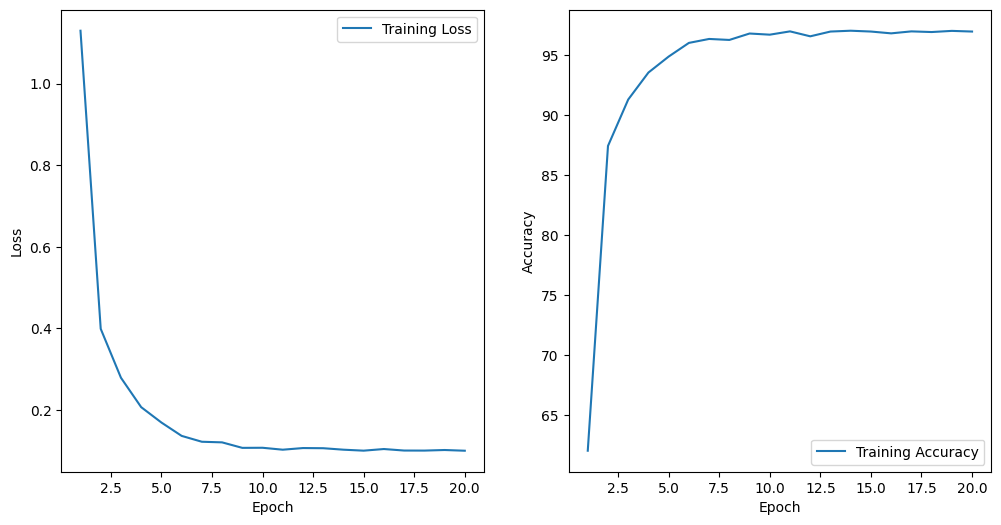

In [8]:
train_lenet5_model(activation='leaky_relu', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.001, dropout_rate=0.5, patience=2)

--------------------------------------------------
Epoch 1/30, Loss: 0.5090,  Accuracy: 83.28%
--------------------------------------------------
Epoch 2/30, Loss: 0.1576,  Accuracy: 95.28%
--------------------------------------------------
Epoch 3/30, Loss: 0.1153,  Accuracy: 96.74%
--------------------------------------------------
Epoch 4/30, Loss: 0.0778,  Accuracy: 97.71%
--------------------------------------------------
Epoch 5/30, Loss: 0.0722,  Accuracy: 97.70%
Test Loss: 0.2641, Test Accuracy:  93.97%
--------------------------------------------------
Epoch 6/30, Loss: 0.0306,  Accuracy: 99.14%
--------------------------------------------------
Epoch 7/30, Loss: 0.0198,  Accuracy: 99.45%
--------------------------------------------------
Epoch 8/30, Loss: 0.0172,  Accuracy: 99.49%
--------------------------------------------------
Epoch 9/30, Loss: 0.0131,  Accuracy: 99.68%
--------------------------------------------------
Epoch 10/30, Loss: 0.0117,  Accuracy: 99.62%
Test Lo

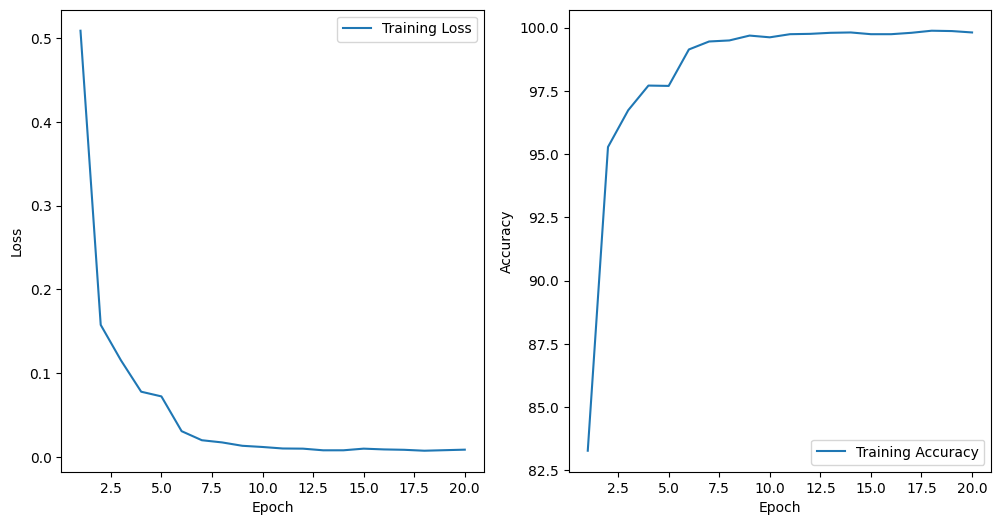

In [9]:
train_lenet5_model(activation='leaky_relu', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.01, dropout_rate=0.1, patience=2)


In [13]:
train_lenet5_model(activation='sigmoid', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.01, dropout_rate=0.0, patience=2)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
train_lenet5_model(activation='relu', loss_function='ce', num_epochs=30, batch_size=64, learning_rate=0.01, dropout_rate=0.0, patience=2)